In [4]:
import tensorflow as tf
import jax
import flax
from flax import linen as nn
from jax import numpy as jnp
from jax import random
from einops import einsum, rearrange
import optax
import matplotlib.pyplot as plt
import pickle

import numpy as np
from flax.training import orbax_utils

import orbax.checkpoint


import os
import uuid
import datetime

from maze_dataset.plotting import MazePlot
from maze_dataset.tokenization.token_utils import strings_to_coords

from dataset import CustomMazeDataset
from dataset import NumpyLoader

from model import TransformerLM, TransformerConfig

# config details
checkpoint_path = "data/2023-10-31_16-24-46"
base_path = "data"
save = True

np_seed = 0
jnp_seed = 0

batch_size = 128
lr = 1e-4
n_train_steps = 10000000

save_every_n_steps = 1000
keep_n_checkpoints = 100

n_worker = 8

# n_eval = 1024
emb_dim: int = 256
num_heads: int = 16
num_layers: int = 12
qkv_dim: int = 256  # 512
mlp_dim: int = 1024  # 2048
max_len = 256

grid_n = 5


@jax.jit
def train_step(state, batch):
    params = state['params']
    opt_state = state['opt_state']
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    step = state['step'] + 1

    return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

@jax.jit
def eval_step(state, batch):
    params = state['params']
    loss = loss_fn(params, batch)
    return loss

dataset = CustomMazeDataset(include_maze=True)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker)

losses = []
eval_losses = []

key = random.PRNGKey(jnp_seed)
rng, key = random.split(key)

config = TransformerConfig(
    vocab_size=dataset.vocab_size,
    output_vocab_size=dataset.vocab_size,
    max_len=max_len,
    emb_dim=emb_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    qkv_dim=qkv_dim,
    mlp_dim=mlp_dim
)

model = TransformerLM(config=config)

def loss_fn(params, batch):
    preds, act = model.apply(params, batch['data'])
    preds = preds[:, 0:-1]
    targets = batch['data'][:, 1:]
    idx = jnp.arange(targets.shape[1])[None, :]
    mask = jnp.where((idx < batch['end_index'][:, None]) & (idx >= batch['start_index'][:, None]), 1., 0.)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=preds,
        labels=targets
    ) * mask

    loss = loss.sum() / mask.sum()

    return loss

tx = optax.adamw(lr)

x = next(iter(train_loader))
params = model.init(rng, x['data'])

apply_fn = jax.jit(model.apply)

opt_state = tx.init(params)

state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

# checkpoint management / loading model

if save and not checkpoint_path:
    # make new run dir ect

    # Get the current date and time
    current_datetime = datetime.datetime.now()

    # Create a directory name with the date and unique ID
    checkpoint_dir_name = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the full path for the checkpoint directory
    checkpoint_path = os.path.join(base_path, checkpoint_dir_name)

    # Check if the directory already exists
    if not os.path.exists(checkpoint_path):
        # Create the directory
        os.makedirs(checkpoint_path)
        print(f"Checkpoint directory created: {checkpoint_path}")
    else:
        print(f"Checkpoint directory already exists: {checkpoint_path}")

if checkpoint_path:
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=keep_n_checkpoints)
    checkpoint_manager = orbax.checkpoint.CheckpointManager(checkpoint_path, orbax_checkpointer, options)

    dummy_dict = {
        'state': state,
        'loss': np.array([0.])}


    step = checkpoint_manager.latest_step()

    if step:
        print(f'loading step {step}')
        load_dict = checkpoint_manager.restore(step, items=dummy_dict)
        state = load_dict['state']
        losses = list(load_dict['loss'])



loading step 505000


In [41]:
model.apply(state["params"], x["data"][:2])

(Array([[[ 1.6147323 , -7.4837537 , -7.802039  , ..., -1.2091814 ,
          -0.03281767, -2.7864423 ],
         [ 9.343205  , -8.067428  , -8.385343  , ...,  1.1211815 ,
           2.12595   , -1.3089246 ],
         [ 5.8180494 , -4.895845  , -5.202928  , ..., -1.7003217 ,
           2.021609  , -0.9804732 ],
         ...,
         [-6.2129717 , -9.8014555 , -9.994341  , ...,  0.79711264,
          -0.7144996 , -4.012033  ],
         [-6.023967  , -9.795838  , -9.985014  , ...,  0.7369838 ,
          -0.5728006 , -3.9918315 ],
         [-5.847716  , -9.7591505 , -9.952374  , ...,  0.65553474,
          -0.48371118, -3.973839  ]],
 
        [[ 1.6147323 , -7.4837537 , -7.802039  , ..., -1.2091814 ,
          -0.03281767, -2.7864423 ],
         [ 8.9302435 , -7.514405  , -7.672109  , ...,  0.31587484,
           2.59833   ,  0.961718  ],
         [ 5.8105164 , -4.9441056 , -5.2326126 , ..., -1.9013425 ,
           2.2087238 , -1.3061802 ],
         ...,
         [-4.1777325 , -6.5113764

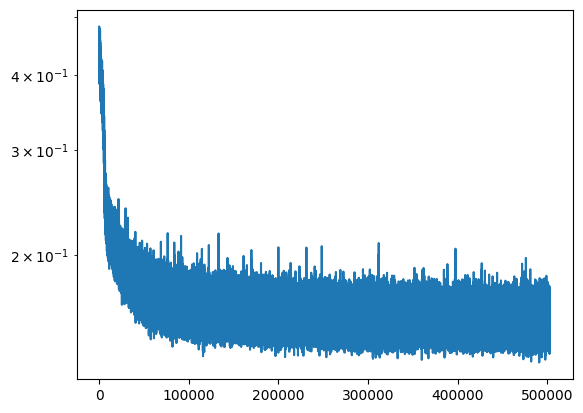

In [8]:
plt.plot(losses)
plt.yscale('log')

In [9]:
reverse_map = {v: k for k, v in dataset.tokenizer.tokenizer_map.items()}
vocab_map = dataset.tokenizer.tokenizer_map.get

from dataset import find_from_right

def ints_to_coords(arr):
    # Map the integers in the list back to their corresponding tokens
    tok_list = [reverse_map.get(i) for i in list(np.array(arr))]
    coords = strings_to_coords(tok_list[:find_from_right(tok_list,'<PATH_END>')])
    return coords


ex 0
[ 6 18 14 12 15 20 27 30 28 33 35  7]
[18 14 12 15 20 27 30 28 33 35]

ex 1
[ 6 29 21 16 18 14 12 11  7]
[29 31 16 18 14 12 11]

ex 2
[ 6 15 12 11  7]
[15 12 11]

ex 3
[ 6 11 12 14 13 16 21 29 31 32 34 35  7]
[11 12 14 13 16 21 29 31 32 34 35]

ex 4
[ 6 28 33 26 24 32 34 35  7]
[28 30 26 24 32 34 35]

ex 5
[ 6 14 17 25 23 26 24 32 34 35 33 28 30 27  7]
[14 17 25 23 26 24 32 34 35 33 28 30 27]

ex 6
[ 6 27  7]
[27]

ex 7
[ 6 17 15 20 27 30 28 33 35  7]
[17 15 20 27 30 28 33 35]

ex 8
[ 6 19 24 22 31 29  7]
[19 24 22 31 29]

ex 9
[ 6 34 26 33 28 23 25 20 27  7]
[34 26 33 35 23 25 20 27]

ex 10
[ 6 15 12 11 13 16 21 29  7]
[15 12 11  7 16 21 29]

ex 11
[ 6 31 32 34 26 33 35  7]
[31 32 34 26 33 28]

ex 12
[ 6 32 34 35 33 28 30 27  7]
[32 34 35 33 28 30 27]

ex 13
[ 6 30 28 23 26 24 32 31 29 21 16 13 11  7]
[30 28 23 26 34 32 31 29 21 16 13 11]

ex 14
[ 6 17 15 12 11 13 16 21 29  7]
[17 15 12 11 13 16 21 29]

ex 15
[ 6 27 30 25 23 19 18 22 21 29  7]
[27 30 25 23 19 18 14 21 29]

ex 16

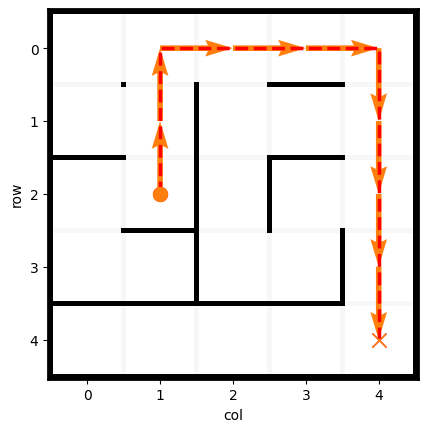

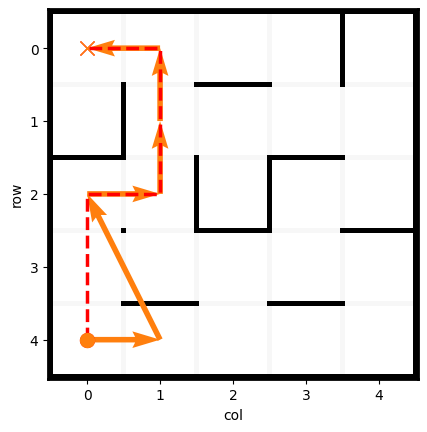

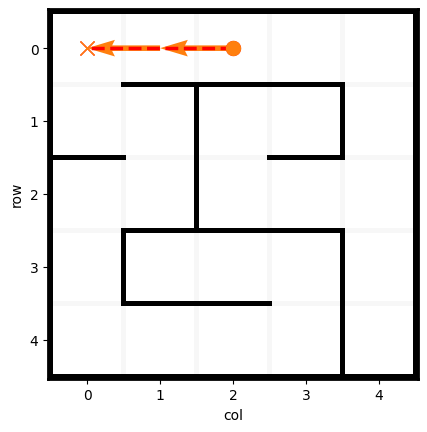

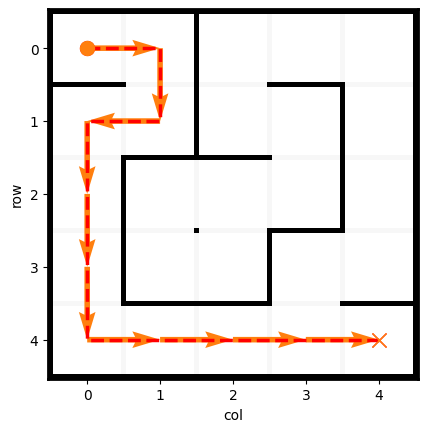

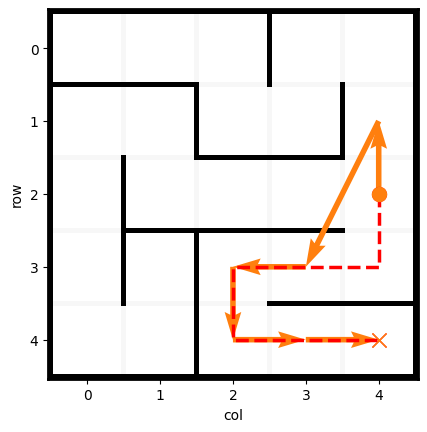

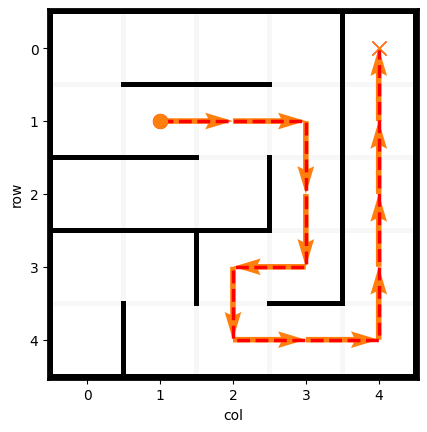

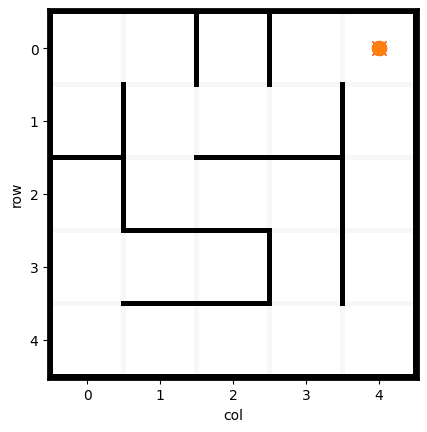

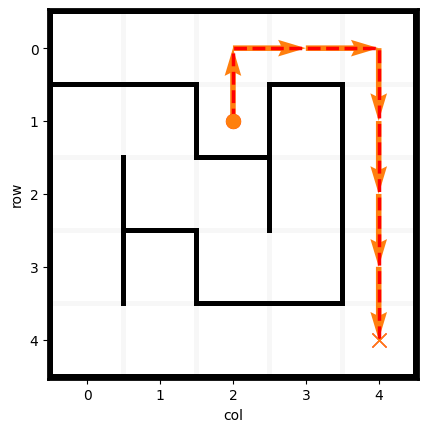

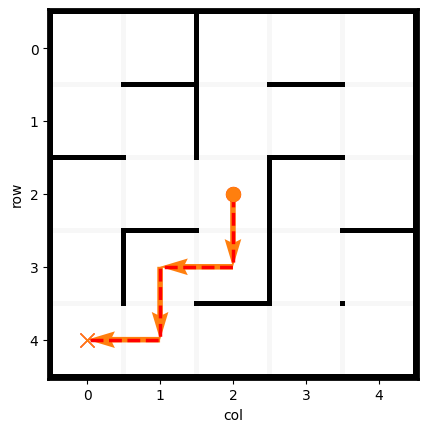

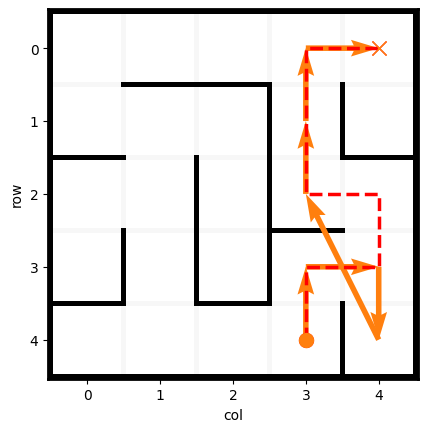

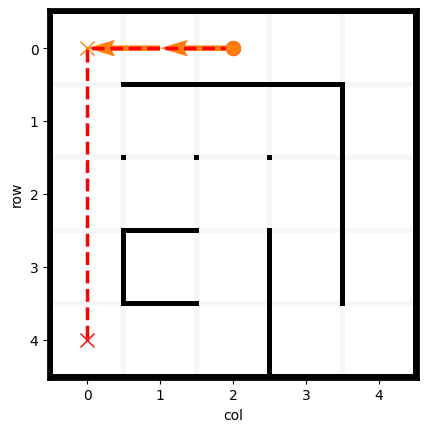

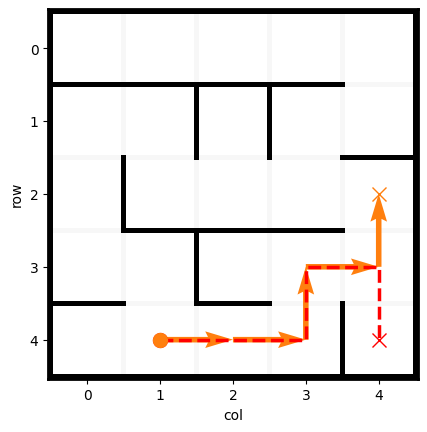

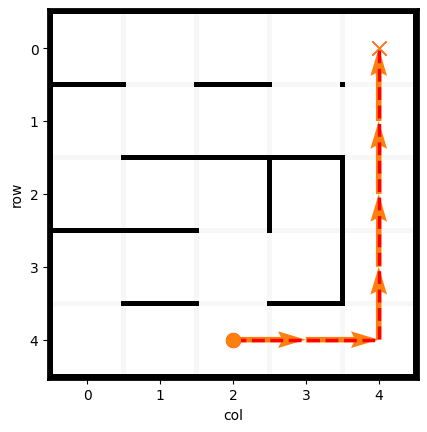

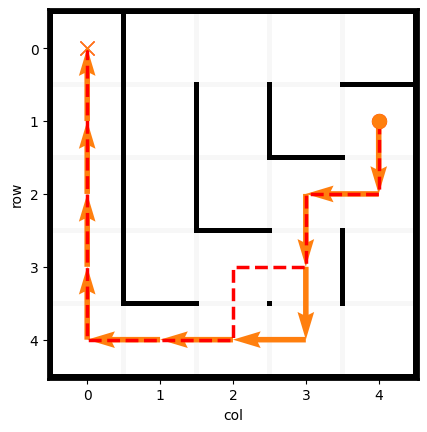

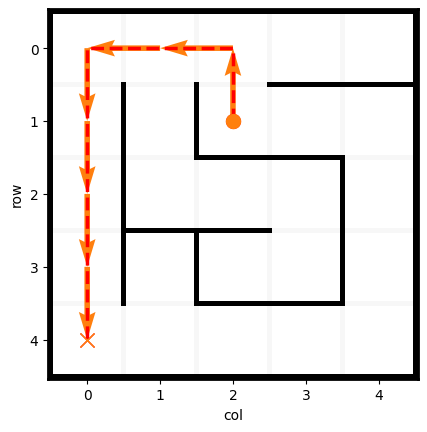

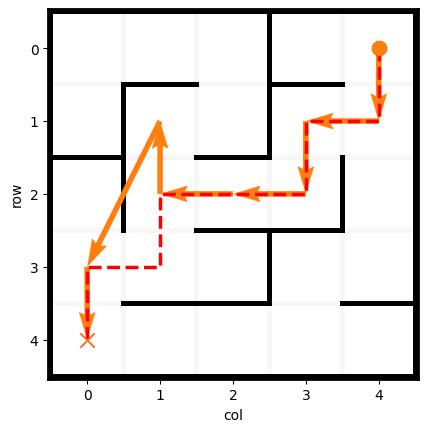

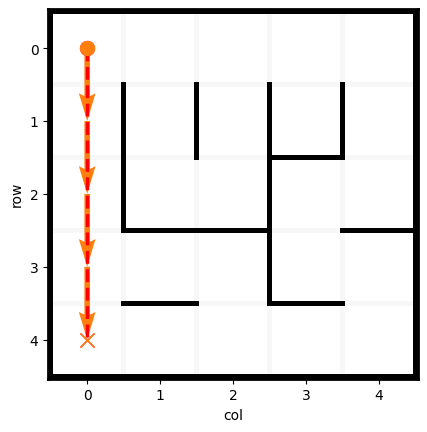

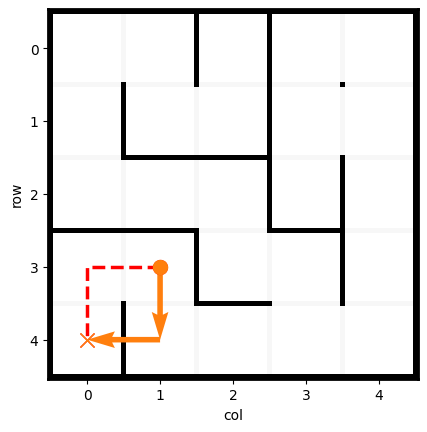

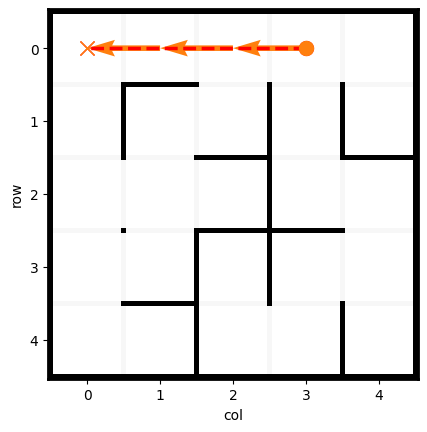

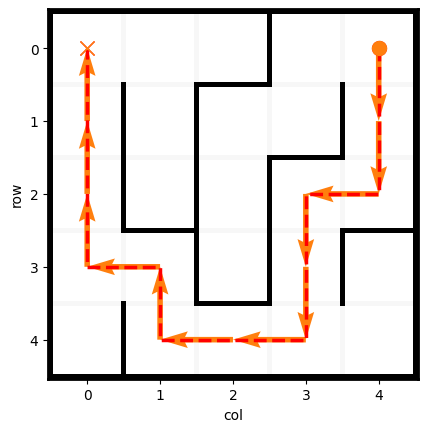

In [10]:
#batch['data'] = batch['data'].at[4,start_indx-3].set(vocab_map('(0,0)')).at[4,start_indx-2].set(vocab_map('(0,0)'))
batch = x
preds, act = model.apply(state['params'],x['data'])

for i in range(20):
  print(f'\nex {i}')

  print(batch['data'][i,x['start_index'][i]:x['end_index'][i]+1])
  print(jnp.argmax(preds[i,x['start_index'][i]:x['end_index'][i]-1],axis=-1))
  plot = MazePlot(x['maze'][i])
  path = ints_to_coords(jnp.argmax(preds[i,x['start_index'][i]:x['end_index'][i]-1],axis=-1))
  plot.add_predicted_path(path)
  plot.plot()

In [59]:
maze_num = 2

x_mod = np.copy(x['data'])
#x_mod[2,x['start_index'][maze_num]+2:x['start_index'][maze_num]+11] = jnp.array([
#    vocab_map('(0,3)'),vocab_map('(0,4)'),vocab_map('(1,4)'),vocab_map('(2,4)'),vocab_map('(3,4)'), vocab_map('(3,3)'), vocab_map('(3,2)'),
#    vocab_map('(4,2)'), vocab_map('(4,3)')])

preds, act = model.apply(state['params'],x_mod)

for t in range(11):
  print(f'\ntime step {t}')
  print(sorted([(reverse_map[i],nn.softmax(preds[maze_num][x['start_index'][maze_num]+t])[i]) for i in range(len(reverse_map))],key=lambda x: -x[1])[:4])


time step 0
[('(1,3)', Array(0.9999976, dtype=float32)), ('(1,1)', Array(7.4417113e-07, dtype=float32)), ('(1,2)', Array(7.3119867e-07, dtype=float32)), ('(0,2)', Array(2.7708955e-07, dtype=float32))]

time step 1
[('(0,3)', Array(0.5002548, dtype=float32)), ('(1,2)', Array(0.49913302, dtype=float32)), ('(2,3)', Array(0.00027737, dtype=float32)), ('(0,1)', Array(6.22437e-05, dtype=float32))]

time step 2
[('(0,4)', Array(0.99996805, dtype=float32)), ('(2,4)', Array(2.879177e-05, dtype=float32)), ('(0,0)', Array(1.3521233e-06, dtype=float32)), ('(2,2)', Array(4.8765736e-07, dtype=float32))]

time step 3
[('<PATH_END>', Array(0.6214403, dtype=float32)), ('(1,4)', Array(0.37828812, dtype=float32)), ('(3,4)', Array(9.048543e-05, dtype=float32)), ('(1,2)', Array(3.6836886e-05, dtype=float32))]

time step 4
[('(2,4)', Array(0.99997795, dtype=float32)), ('(3,3)', Array(7.78541e-06, dtype=float32)), ('(2,2)', Array(6.951987e-06, dtype=float32)), ('(1,0)', Array(1.2577087e-06, dtype=float32))]

# Attempting probe training in this notebook

In [11]:
class LinearProbe(nn.Module):

  @nn.compact
  def __call__(self,x):
    #y = nn.Dense(features=128)(x)
    #y = nn.relu(y)
    #y = nn.Dense(features=64)(x)
    #y = nn.relu(y)
    x = nn.Dense(features=4)(x)
    return x


def concat_acts(act, first_layer, last_layer):
  assert len(act['stream'])>=last_layer
  stream = act['stream'][first_layer:last_layer+1]
  #concat along model dim (i.e. keep batch and sequence positions separate)
  acts = jnp.concatenate(stream,axis=-1)
  #print(acts.shape)
  #acts = acts[:,:,:]
  #print(acts.shape)
  return acts


In [12]:
# Linear probe training

# Start a new experiment


first_layer = 9

last_layer = 9


losses = []
eval_losses = []


key = random.PRNGKey(0)

rng, key = random.split(key)


#print(f'default loss: {jnp.log()}')

pred, act = model.apply(state['params'], batch['data'])

acts = concat_acts(act,first_layer,last_layer)[:,0,:] # this is just to initialize the probe, so take first sequence position arbitrarily

x = acts

probe = LinearProbe()

tx = optax.adamw(1e-4)

params = probe.init(rng,x)

opt_state = tx.init(params)

probe_state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}


target_dict = {
      11: 0,
      27: 1,
      29: 2,
      35: 3
  }


def probe_loss_fn(params, batch):
  pred, act = model.apply(state['params'], batch['data'])
      
  acts = concat_acts(act,first_layer, last_layer)

  assert len(acts.shape) == 3

  probe_inputs = acts.reshape(-1,acts.shape[-1]) # put all sequence positions in one gigantic batch


  targets = batch['data'][jnp.arange(0,pred.shape[0]),batch['end_index']-1]

  #print(targets)

  new_targets = targets.copy()

  for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

  #print(new_targets)

  repeated_targets = jnp.repeat(new_targets, acts.shape[1], axis = 0)

  probe_pred = probe.apply(params, probe_inputs)

  assert repeated_targets.shape == probe_inputs.shape[:-1]

  assert len(repeated_targets.shape)==1

  # now mask all the irrelevant positions

  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits = probe_pred,
      labels = repeated_targets
  )
  
  idx = jnp.arange(batch['data'].shape[1])[None, :]

  mask = jnp.where((idx <= batch['end_index'][:, None]-1) & (idx >= batch['start_index'][:, None]+2), 1., 0.)
    
  loss = loss.reshape(batch['data'].shape) * mask

  loss = loss.sum() / mask.sum()

  return loss

@jax.jit
def probe_train_step(probe_state,batch):
  params = probe_state['params']
  opt_state = probe_state['opt_state']
  loss, grads = jax.value_and_grad(probe_loss_fn)(params,batch)
  updates, opt_state = tx.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  step = probe_state['step'] + 1

  return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

@jax.jit
def probe_eval_step(state,batch):
  params = state['params']
  loss = probe_loss_fn(params,batch)
  return loss

probe_losses = []
probe_eval_losses = []



In [13]:
dataset = CustomMazeDataset(include_maze=False)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker)

for n, batch in enumerate(train_loader):
    # do the actual training


    probe_state = probe_train_step(probe_state, batch)
    
    probe_losses.append(probe_state['loss'])
    
    print(f'step: {probe_state["step"]}')
    print('loss: {}'.format(probe_state['loss']))


# note that completely oblivious loss is 1.3862944 for 4 options (since dataset is uniformly random)

XlaRuntimeError: UNKNOWN: /var/folders/pc/8rgjvxmn1s7cssf2g_rh46ph0000gn/T/ipykernel_15730/3971439515.py:78:9: error: failed to legalize operation 'mhlo.scatter'
/var/folders/pc/8rgjvxmn1s7cssf2g_rh46ph0000gn/T/ipykernel_15730/3971439515.py:78:9: note: see current operation: 
%2498 = "mhlo.scatter"(%151, %157, %2497) ({
^bb0(%arg11: tensor<f32>, %arg12: tensor<f32>):
  %2554 = "mhlo.add"(%arg11, %arg12) : (tensor<f32>, tensor<f32>) -> tensor<f32>
  "mhlo.return"(%2554) : (tensor<f32>) -> ()
}) {indices_are_sorted = true, scatter_dimension_numbers = #mhlo.scatter<update_window_dims = [0], inserted_window_dims = [1], scatter_dims_to_operand_dims = [1]>, unique_indices = true} : (tensor<16512x1xf32>, tensor<1xsi32>, tensor<16512xf32>) -> tensor<16512x1xf32>


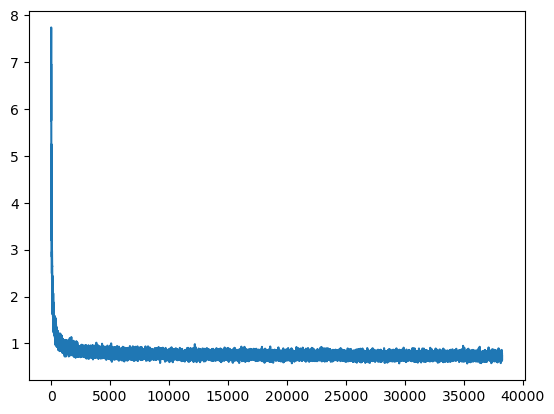

In [99]:
plt.plot(probe_losses)

# Probe analysis

In [134]:
def get_probe_probs(probe_params, batch):
  pred, act = model.apply(state['params'], batch['data'])
      
  acts = concat_acts(act,first_layer, last_layer)

  assert len(acts.shape) == 3

  probe_inputs = acts.reshape(-1,acts.shape[-1]) # put all sequence positions in one gigantic batch

  probe_preds = probe.apply(probe_params, probe_inputs)

  probe_probs = nn.softmax(probe_preds, axis=-1)

  #undo the batching again. Have a new dimension with the 4 probe probabilities now

  return probe_probs.reshape(batch['data'].shape + (4,))

target_dict = {
      11: 0,
      27: 1,
      29: 2,
      35: 3
  }

In [103]:
dataset = CustomMazeDataset(include_maze=True)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=0)

x = next(iter(train_loader))


ex 0
[0 0 0 0 0 0 0 0 0 0 0]
[27 30 28 23 26 34 32 31 29]

ex 1
[21  8 29  9  1  4 22  5  6 22 31]
[15 20 14 13 22 24 32 31 29]

ex 2
[ 1  4 32  5  6 32 31 29 21 16 13 11 12 15 20 27  7]
[11 13 16 17 25 23 19 18 22 24 26 33 28 30 27]

ex 3
[ 6 19 23]
[27]

ex 4
[21 16 13 11  7  0  0  0  0  0  0  0  0  0  0]
[14 17 25 23 28 33 35  7 26 24 32 31 29]

ex 5
[ 1  4 17  5  6]
[16 13 29]

ex 6
[ 1  4 11  5  6 11  7  0  0  0  0  0  0  0  0]
[32 34 35 33 28 23 25 17 19 18 16 21 29]

ex 7
[ 6 35 34 32 31 29 21 16 13 11  7  0  0  0  0  0  0  0]
[20 15 17 19 18 14 13 16 21 29 31 22 24 26 33 35]

ex 8
[33 35  7  0  0  0  0  0  0  0]
[33 28 30 27 20 15 12 11]

ex 9
[18  8 22  9  1  4]
[33 28 23 27]

ex 10
[ 1  4 13  5  6 13 14 18 22 24]
[24 26 23 25 17 15 20 11]

ex 11
[16  8 21  9  1]
[26 34 35]

ex 12
[ 6 27  7  0  0]
[16 13 29]

ex 13
[25 17 14 12 11  7  0]
[35 33 28 30 27]

ex 14
[ 1  4 30  5  6 30 28]
[19 24 26 34 32]

ex 15
[23  8 25  9 32  8 34  9  1  4]
[18 19 13 11  7 15 20 27]

ex 16
[ 6 

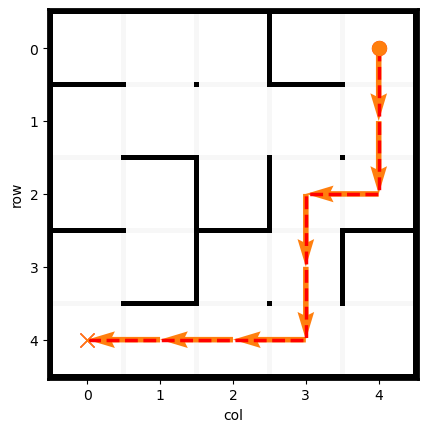

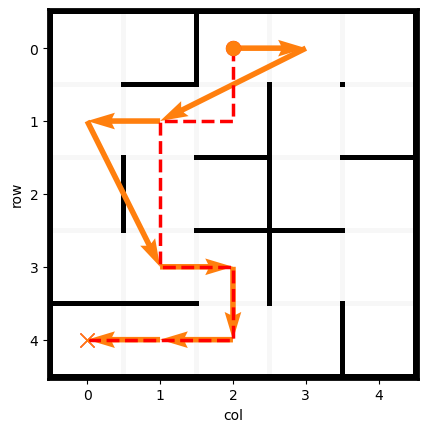

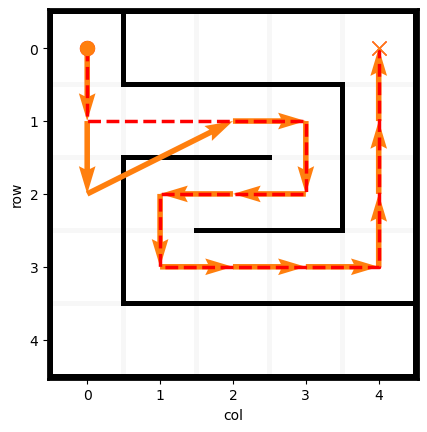

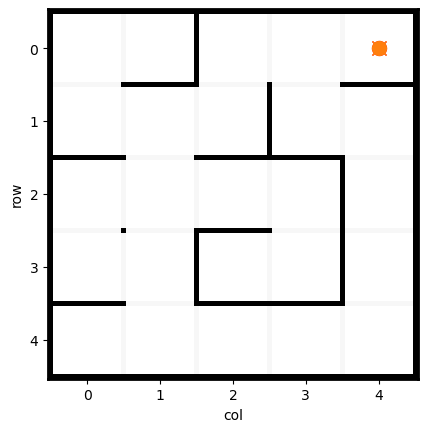

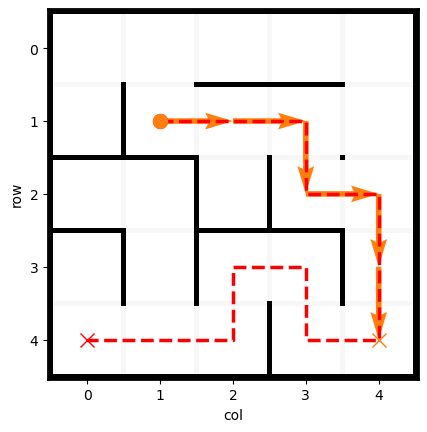

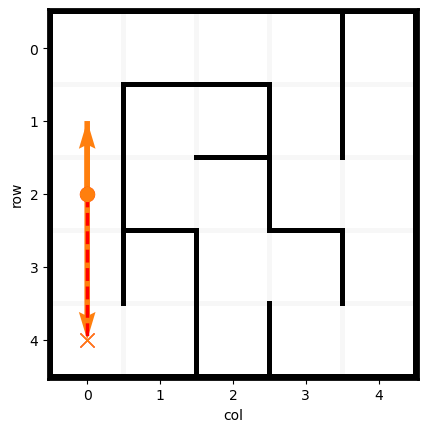

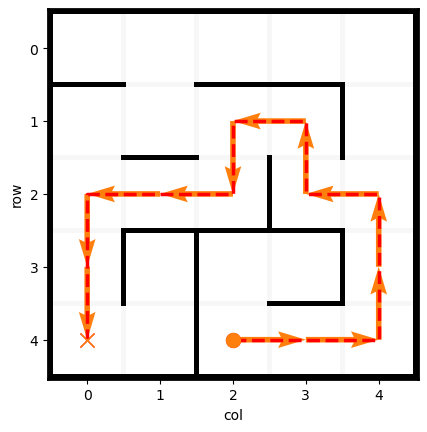

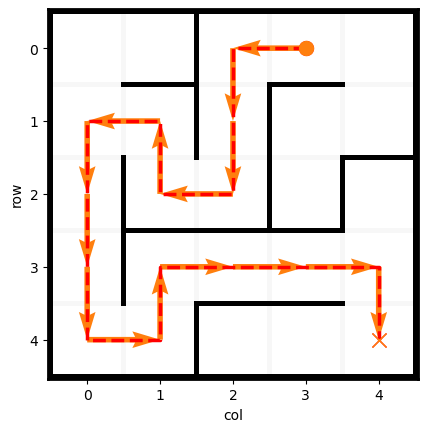

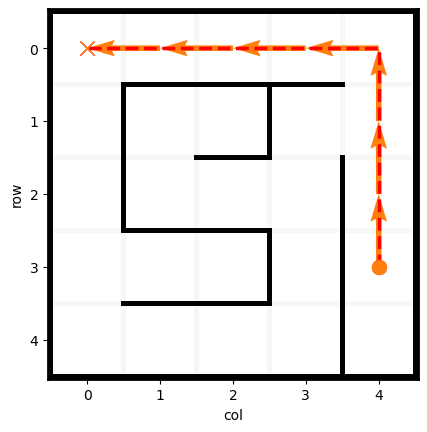

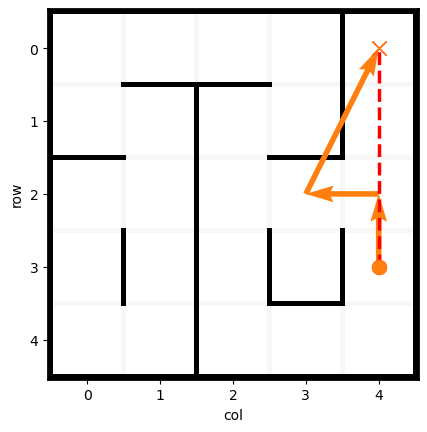

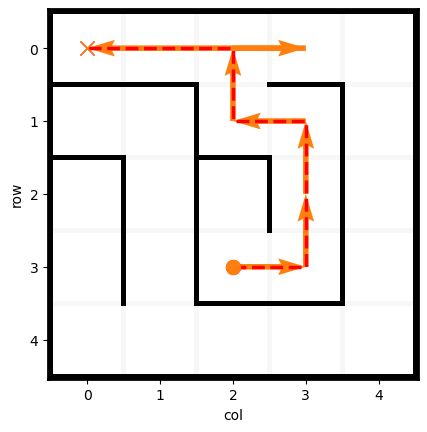

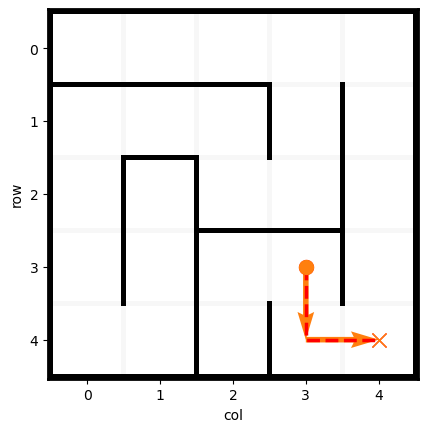

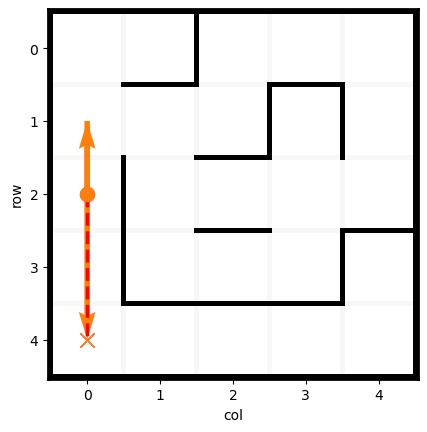

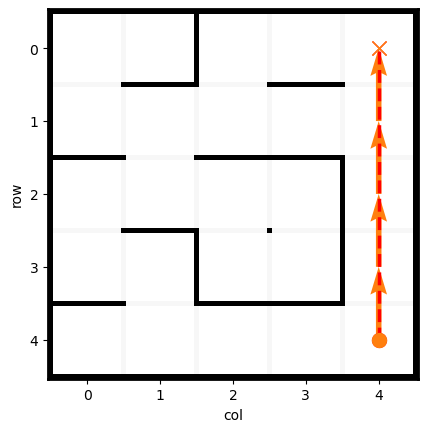

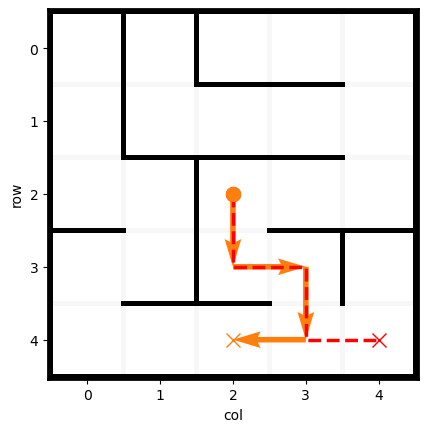

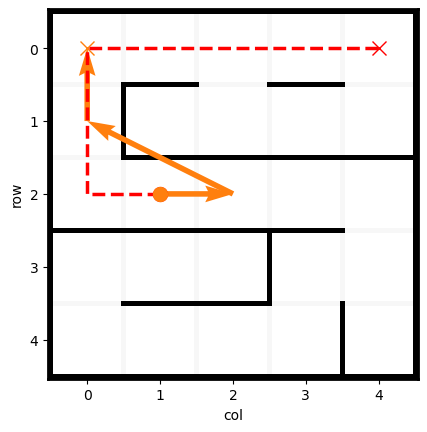

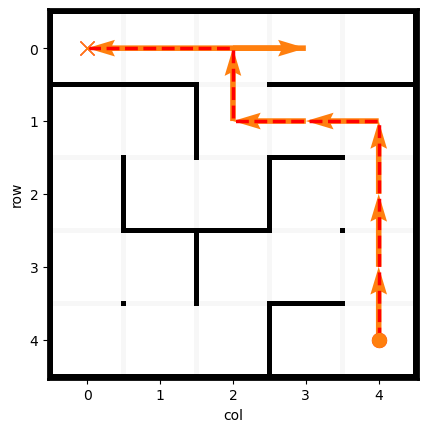

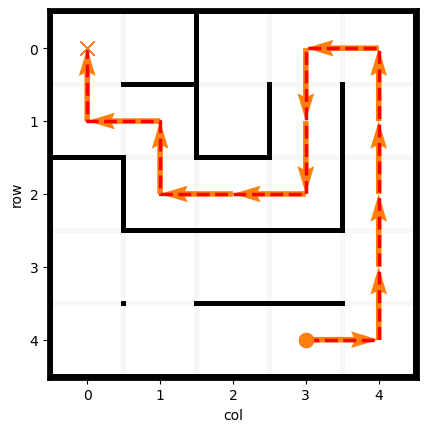

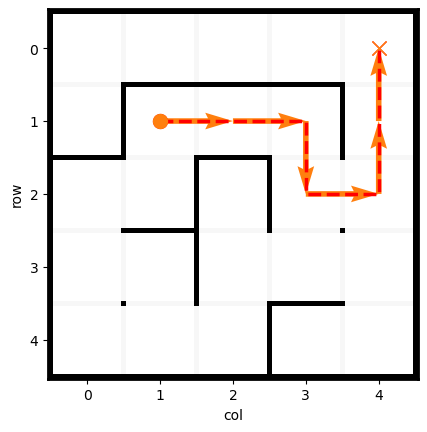

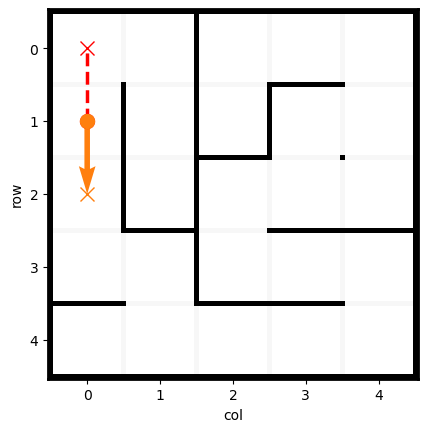

In [126]:
# first, print the mazes again

preds, act = model.apply(state['params'],x['data'])

for i in range(20):
  print(f'\nex {i}')

  print(batch['data'][i,x['start_index'][i]:x['end_index'][i]+1])
  print(jnp.argmax(preds[i,x['start_index'][i]:x['end_index'][i]-1],axis=-1))
  plot = MazePlot(x['maze'][i])
  path = ints_to_coords(jnp.argmax(preds[i,x['start_index'][i]:x['end_index'][i]-1],axis=-1))
  plot.add_predicted_path(path)
  plot.plot()

In [133]:
print(probe_probs[0][x['start_index'][0]:])

[[9.9850416e-01 9.3503608e-11 1.5187031e-07 1.4956949e-03]
 [9.1042170e-07 4.1186698e-03 2.4163975e-07 9.9588013e-01]
 [3.8475917e-13 1.0000000e+00 1.3713199e-10 6.9750703e-12]
 [9.2866111e-01 7.1338825e-02 1.1548925e-09 6.8378874e-08]
 [9.8302400e-01 1.6934223e-02 7.5320216e-08 4.1681051e-05]
 [2.0613623e-01 7.9321390e-01 3.1409422e-06 6.4679841e-04]
 [6.1961160e-05 9.9969792e-01 2.4002415e-04 8.5717403e-08]
 [6.9313519e-09 9.9994230e-01 5.7703026e-05 3.2569680e-12]
 [1.3797243e-02 6.9871326e-06 5.6166511e-05 9.8613954e-01]
 [1.4788593e-03 9.7087258e-01 2.2765134e-04 2.7420847e-02]
 [9.5019472e-01 2.8845093e-15 1.6241223e-05 4.9789000e-02]
 [9.9674809e-01 1.8261615e-04 1.0432664e-03 2.0259821e-03]
 [9.9811220e-01 8.6866050e-05 6.5836962e-04 1.1425839e-03]
 [9.9852222e-01 4.5159548e-05 6.4475916e-04 7.8792521e-04]
 [9.9849939e-01 2.3573562e-05 8.1783440e-04 6.5916637e-04]]


In [139]:
maze_num = 0

import copy

x_mod = copy.deepcopy(x)

x_mod['data'][maze_num][x_mod['start_index'][maze_num]+7] = vocab_map('(4,4)')


preds, act = model.apply(state['params'],x_mod['data'])

probe_probs = get_probe_probs(probe_state['params'],x_mod)

# probe was only trained for indices start_index+2 until end_index-3
for t in range(x_mod['start_index'][maze_num]+2,x_mod['end_index'][maze_num]-2):
  print('\ntime step {}'.format(t-x_mod['start_index'][maze_num]))
  print('maze transformer prediction')
  print(sorted([(reverse_map[i],nn.softmax(preds[maze_num][t])[i]) for i in range(len(reverse_map))],key=lambda x: -x[1])[:4])
  print('probe probs:')

  step_probs = sorted([(reverse_map[pos],probe_probs[maze_num][t][i]) for pos, i in target_dict.items()],key=lambda x: -x[1])[:4]
  print(step_probs)
  print('target:')
  print(reverse_map[x_mod['data'][maze_num][x_mod['end_index'][maze_num]-1]])


time step 2
maze transformer prediction
[('(2,4)', Array(0.69578236, dtype=float32)), ('(1,3)', Array(0.30343968, dtype=float32)), ('(0,4)', Array(0.00059367, dtype=float32)), ('(2,2)', Array(3.0003948e-05, dtype=float32))]
probe probs:
[('(4,0)', Array(0.34613225, dtype=float32)), ('(4,4)', Array(0.32847583, dtype=float32)), ('(0,0)', Array(0.30212176, dtype=float32)), ('(0,4)', Array(0.02327015, dtype=float32))]
target:
(4,0)

time step 3
maze transformer prediction
[('(2,3)', Array(0.9999149, dtype=float32)), ('(3,4)', Array(4.316893e-05, dtype=float32)), ('(1,2)', Array(2.0228412e-05, dtype=float32)), ('(2,1)', Array(6.753922e-06, dtype=float32))]
probe probs:
[('(4,4)', Array(0.59070855, dtype=float32)), ('(4,0)', Array(0.4011214, dtype=float32)), ('(0,0)', Array(0.00666791, dtype=float32)), ('(0,4)', Array(0.00150211, dtype=float32))]
target:
(4,0)

time step 4
maze transformer prediction
[('(3,3)', Array(0.9999491, dtype=float32)), ('(3,1)', Array(1.9609097e-05, dtype=float32))